In [2]:
import numpy as np
import pandas as pd
import bootcampviztools as bt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression                     # Requiere Standardization
from sklearn.ensemble import RandomForestClassifier                     # Randomforest usa múltiples árboles para promediar las predicciones, reduciéndo la varianza

In [3]:
df = pd.read_excel("./scr/data/raw.xlsx")

In [4]:
df.sample(5)

,ID asociado a venta,Persona - ID,País,Códigos promocionales utilizados en la venta,Tienda asociada a la venta,Productos comprados,Fecha de la venta,ventas asociadas al cliente,total pagado
78466,32522020865,1447969,España,"NPP:Club5,NPP:Club5,NPP:FILM TRASERO 20%,NPP:C...",325,"Protector de Pantalla Film para móvil,Funda Re...",2024-10-11 02:06:30,2,48.56
53674,169192144639,1326419,España,NPP:CONMAG,169,"POWERBANK MAGBATTERY ACCESORIOS PE10,WAVE CASE...",2024-08-28 08:10:55,2,104.96
76419,16719099989,1425761,España,NPP:Club5,167,Funda Glitter Premium para iPhone 11,2024-10-02 08:34:54,4,17.99
31451,4417134451,1256789,España,NaN,44,"LEATHER CON CUBRECAMARA XIAOMI RMA3,CORDON PRE...",2024-08-03 01:21:47,2,27.97
28884,351230007371,1247440,España,"NPP:Club5,NPP:Club5,NPP:Club5,NPP:3CS MOVIL,NP...",351,"BUMPER LOGO MAGBATTERY APPLE 14MX/IP14 PR MX,L...",2024-08-02 03:16:26,2,49.75


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81937 entries, 0 to 81936
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ID asociado a venta                            81937 non-null  int64  
 1   Persona - ID                                   81937 non-null  int64  
 2   País                                           81937 non-null  object 
 3    Códigos promocionales utilizados en la venta  58867 non-null  object 
 4   Tienda asociada a la venta                     81937 non-null  int64  
 5   Productos comprados                            81653 non-null  object 
 6   Fecha de la venta                              81937 non-null  object 
 7   ventas asociadas al cliente                    81937 non-null  int64  
 8   total pagado                                   81937 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 5.

In [6]:
def get_cardinality(df:pd.DataFrame, threshold_categorical=10, threshold_continuous=30):
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expected a pandas DataFrame")
    
    print('pandas.DataFrame shape: ', df.shape)
    
    df_out = pd.DataFrame([df.nunique(), df.nunique()/len(df) * 100, df.isna().sum(), df.dtypes])
    df_out = df_out.T.rename(columns = {0: 'Cardinality', 1: '%_Card', 2: 'NaN_Values', 3: 'Type'})
    
    df_out.loc[df_out['Cardinality'] < threshold_categorical, 'Class'] = 'Categoric'    
    df_out.loc[df_out['Cardinality'] == 2, 'Class'] = 'Binary'
    df_out.loc[df_out['Cardinality'] >= threshold_categorical, 'Class'] ='Numeric - Discrete'
    df_out.loc[df_out['%_Card'] > threshold_continuous, 'Class'] = 'Numeric - Continuous'
    
    return df_out


In [7]:
get_cardinality(df)

pandas.DataFrame shape:  (81937, 9)


,Cardinality,%_Card,NaN_Values,Type,Class
ID asociado a venta,75127,91.688736,0,int64,Numeric - Continuous
Persona - ID,37893,46.246506,0,int64,Numeric - Continuous
País,1,0.00122,0,object,Categoric
Códigos promocionales utilizados en la venta,3030,3.697963,23070,object,Numeric - Discrete
Tienda asociada a la venta,271,0.330742,0,int64,Numeric - Discrete
Productos comprados,47571,58.05802,284,object,Numeric - Continuous
Fecha de la venta,80601,98.369479,0,object,Numeric - Continuous
ventas asociadas al cliente,34,0.041495,0,int64,Numeric - Discrete
total pagado,3529,4.306968,0,float64,Numeric - Discrete


In [8]:
df.rename(columns={'ID asociado a venta ':'id_venta',
                   'Persona - ID':'id_persona',
                   ' Códigos promocionales utilizados en la venta': 'num_promociones',
                   'Tienda asociada a la venta': 'codigo_tienda',
                   'ventas asociadas al cliente ':'num_ventas_target',
                   'Productos comprados ':'num_productos',
                   'Fecha de la venta':'fecha',
                   'total pagado':'precio'}, inplace=True)

VAMOS A LIMPIAR FILAS

In [9]:
df.head()

,id_venta,id_persona,País,num_promociones,codigo_tienda,num_productos,fecha,num_ventas_target,precio
0,6817080387,727988,España,NaN,68,"Funda Ultra suave para iPhone 14,Protector de ...",2024-01-12 07:37:14,2,19.99
1,11519078527,750466,España,NaN,115,Power Bank compatible con Magsafe 10000 mAh - ...,2024-01-17 09:10:33,2,102.54
2,118232013601,750751,España,NaN,118,"Funda EcoCase - Biodegradable para iPhone 13,C...",2024-01-17 09:11:50,2,27.77
3,12819095095,750857,España,NaN,128,Funda Bumper Ultra Suave para Samsung Galaxy A...,2024-01-17 09:13:35,2,38.76
4,16619048201,740049,España,NaN,166,Cristal Templado Completo Irrompible para iPho...,2024-01-17 09:39:33,2,83.74


1.- COLUMNA ID_VENTA

Vamos a examinar la columna id_venta, ya que en prinicpio cada valor debería ser único

In [10]:
resultado_cero = df[df['id_venta'] == 0]
resultado_cero

,id_venta,id_persona,País,num_promociones,codigo_tienda,num_productos,fecha,num_ventas_target,precio
11773,0,1110233,España,NaN,308,"Pulverizador de Pantallas,Cubre Objetivo Fluor...",2024-07-17 19:04:51,2,93.91
25792,0,1240912,España,NaN,262,Funda Iron Logo Compatible con MagSafe para iP...,2024-08-01 13:34:10,2,16.99
39644,0,1286572,España,NaN,57,CARGADOR MAGBATTERY ACCESORIOS NEWMAGBATTERY,2024-08-07 13:35:55,4,13.99
41188,0,1264063,España,NaN,92,Cristal Templado Completo para Vivo Y36,2024-08-09 13:27:06,2,12.99
42904,0,1322179,España,NaN,245,Cristal Templado Irrompible Mate para iPhone 1...,2024-08-11 16:34:52,2,48.96
58359,0,1427012,España,NaN,57,Protector de Pantalla Film para móvil,2024-09-06 05:30:30,3,18.99
73600,0,1081303,España,NaN,134,"Protector de Pantalla Film para móvil,LIBRO IM...",2024-09-25 10:58:36,2,33.99


Elimnamos los id_venta = 0, son confusos

In [11]:
df = df[df['id_venta'] != 0]

In [12]:
df['id_venta'].value_counts()

id_venta
32822010247     3
3451008573      3
351230011274    3
6917152299      3
27221035253     2
               ..
10620098005     1
17720068046     1
284211079065    1
86231013457     1
554440          1
Name: count, Length: 75126, dtype: int64

Por lo demás, hay muchos ID_VENTA repetidos\
Conservaremos la fila que que tenga el valor más alto en la columna PRECIO. Si todos los valores de PRECIO son iguales, entonces nos quedaremos con la primera fila encontrada 

In [13]:
df = df.loc[df.groupby('id_venta')['precio'].idxmax()]

In [14]:
df['id_venta'].value_counts()

id_venta
31950            1
62203071230      1
62203071483      1
62203071471      1
62203071446      1
                ..
16419063138      1
16419063132      1
16419063113      1
16419063092      1
3642400003082    1
Name: count, Length: 75126, dtype: int64

Ya no hay valores repetidos

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75126 entries, 8418 to 78124
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_venta           75126 non-null  int64  
 1   id_persona         75126 non-null  int64  
 2   País               75126 non-null  object 
 3   num_promociones    54107 non-null  object 
 4   codigo_tienda      75126 non-null  int64  
 5   num_productos      74886 non-null  object 
 6   fecha              75126 non-null  object 
 7   num_ventas_target  75126 non-null  int64  
 8   precio             75126 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 5.7+ MB


2.- COLUMNA ID_PERSONA

En este dataframe, cada venta es una fila, de forma que si un cliente ha realizado 3 compras, aparacerán 3 filas con ese mismo ID_PERSONA\
Eso implica que los clientes cuya "id_persona" aparece 1 sola vez, han realizado 1 sola compra.\
Para ese ejercicio solo nos interesan los clientes con dos o más compras, así que hay que eliminar los clientes cuya "id_persona" aparezca 1 sola vez

In [16]:
# Filtrar las filas que no tienen valores duplicados en la columna 'id_persona'
df = df[df['id_persona'].duplicated(keep=False)]
df.sort_values(by='id_persona')

,id_venta,id_persona,País,num_promociones,codigo_tienda,num_productos,fecha,num_ventas_target,precio
50552,118232018141,723543,España,NaN,118,ADAPTACIÓN DE COLGANTE ACCESORIOS ADAP/COLGANT...,2024-08-24 15:59:10,2,4.98
689,323220003522,723543,España,NaN,323,Pack de imanes para móvil - Soporte de móvil,2024-02-08 06:52:05,2,1.99
18486,3451008803,727451,España,NaN,345,Funda Bumper Reforzada Degradada compatible co...,2024-07-23 00:50:52,5,30.97
49100,3451010550,727451,España,NPP:Club5,345,ENCHUFE CARGADOR ACCESORIOS PD25,2024-08-23 02:44:37,5,19.99
51356,3451010736,727451,España,"NPP:Club5,NPP:Club5,NPP:Club5",345,"Funda Bumper Eco para iPhone 15 Pro Max,Funda ...",2024-08-25 10:19:14,5,31.97
...,...,...,...,...,...,...,...,...,...
69740,63201042675,1562998,España,NaN,63,MULTIENGANCHE REFORZ TRANSP SAMSUNG SA54,2024-09-19 04:53:49,2,14.99
76653,6317169334,1562998,España,NaN,63,Funda Bumper Compatible con Magsafe para iPhon...,2024-10-02 22:15:37,2,19.99
74525,2242420004759,1563021,España,NaN,224,"Funda Libro Suave para Poco C65,CUBRE OBJETIVO...",2024-09-27 06:01:19,3,21.99
69741,22417143166,1563021,España,NaN,224,Cubre Objetivo para iPhone 15 Pro,2024-09-19 04:55:21,3,6.99


3.- COLUMNA PAÍS

In [17]:
df.País.value_counts()

País
España    66508
Name: count, dtype: int64

Siempre es el mismo valor, borramos la columna

In [18]:
df = df.drop(["País"], axis=1)

4.- COLUMNA NUM_PROMOCIONES

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66508 entries, 8418 to 76536
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_venta           66508 non-null  int64  
 1   id_persona         66508 non-null  int64  
 2   num_promociones    48024 non-null  object 
 3   codigo_tienda      66508 non-null  int64  
 4   num_productos      66289 non-null  object 
 5   fecha              66508 non-null  object 
 6   num_ventas_target  66508 non-null  int64  
 7   precio             66508 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 4.6+ MB


Transformamos a numéricos los valores

In [20]:
df.num_promociones.value_counts()

num_promociones
NPP:Club5                                                                                       11690
NPP:Club5,NPP:Club5                                                                              8006
NPP:Club5,NPP:Club5,NPP:Club5                                                                    4348
NPP:Club5,NPP:Club5,NPP:Club5,NPP:Club5                                                          1688
NPP:FILM TRASERO 20%                                                                              701
                                                                                                ...  
NPP:AUDIO,NPP:Club5,club5,NPP:Club5,club5,NPP:FILM TRASERO 20%                                      1
NPP:AUDIO,NPP:CONMAG,NPP:FILM TRASERO 20%                                                           1
NPP:Club5,NPP:Club5,NPP:08 PACK ES,NPP:07 PACK ES,NPP:07 PACK ES,NPP:07 PACK ES                     1
NPP:50%AUDIO-PTE-SP,NPP:Club5,NPP:Club5,NPP:PRB ESP,NPP:Club5,NPP:

In [21]:
df['num_promociones'] = df['num_promociones'].str.split(',').str.len()

In [22]:
df.num_promociones.value_counts()

num_promociones
1.0     17184
2.0     11671
3.0      7712
4.0      5266
5.0      2362
6.0      1813
7.0       733
8.0       558
9.0       242
10.0      200
11.0       95
12.0       58
13.0       28
14.0       27
15.0       21
16.0       16
17.0       12
18.0       11
19.0        4
22.0        3
20.0        2
21.0        2
24.0        2
33.0        1
65.0        1
Name: count, dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66508 entries, 8418 to 76536
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_venta           66508 non-null  int64  
 1   id_persona         66508 non-null  int64  
 2   num_promociones    48024 non-null  float64
 3   codigo_tienda      66508 non-null  int64  
 4   num_productos      66289 non-null  object 
 5   fecha              66508 non-null  object 
 6   num_ventas_target  66508 non-null  int64  
 7   precio             66508 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 4.6+ MB


Quedan nulos, así que convertimos a 0 todos los valores nulos

In [24]:
df['num_promociones'] = df['num_promociones'].fillna(0)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66508 entries, 8418 to 76536
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_venta           66508 non-null  int64  
 1   id_persona         66508 non-null  int64  
 2   num_promociones    66508 non-null  float64
 3   codigo_tienda      66508 non-null  int64  
 4   num_productos      66289 non-null  object 
 5   fecha              66508 non-null  object 
 6   num_ventas_target  66508 non-null  int64  
 7   precio             66508 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 4.6+ MB


Ya no hay nulos

4.- COLUMNA PRODUCTOS

In [26]:
df.head()

,id_venta,id_persona,num_promociones,codigo_tienda,num_productos,fecha,num_ventas_target,precio
8418,31950,1066609,1.0,238,SOPORTE ACCESORIOS VENT,2024-06-25 03:03:45,2,0.01
8596,31980,1069011,0.0,238,"FUNDA IMD PREMIUM APPLE I14P,SOPORTE ACCESORIO...",2024-06-25 07:28:06,2,22.97
25403,35214,1237721,0.0,238,"Funda Ultra suave para iPhone 12,Protector de ...",2024-08-01 05:31:56,2,30.97
53538,40016,1077851,1.0,238,Funda Compatible con Magsafe Ring para iPhone ...,2024-08-28 05:02:58,2,58.73
67411,44649,1459168,0.0,238,Cubre Objetivo Fluorescente para iPhone 12 Pro...,2024-09-17 00:59:24,2,7.99


In [27]:
df[df['num_productos'].isnull()]

,id_venta,id_persona,num_promociones,codigo_tienda,num_productos,fecha,num_ventas_target,precio
61205,373319,859351,0.0,29,NaN,2024-09-09 17:58:28,2,0.00
5368,2617142601,975815,0.0,26,NaN,2024-03-26 21:35:21,2,12.99
61156,3417152994,853222,0.0,34,NaN,2024-09-09 17:54:18,2,0.00
61179,3417153072,857129,0.0,34,NaN,2024-09-09 17:56:07,2,0.00
19105,3417158611,1160834,3.0,34,NaN,2024-07-23 14:47:26,2,0.00
...,...,...,...,...,...,...,...,...
73780,351230011274,1266368,0.0,351,NaN,2024-09-26 01:20:49,5,0.00
61165,357230000044,846595,0.0,357,NaN,2024-09-09 17:55:17,7,0.00
61178,357230000076,835571,0.0,357,NaN,2024-09-09 17:56:07,5,0.00
61187,357230000078,857859,0.0,357,NaN,2024-09-09 17:56:20,3,0.00


Para empezar, cambiamos los valores nulos por 'desconocido'

In [28]:
df['num_productos'] = df['num_productos'].fillna('desconocido')

In [29]:
df[df['num_productos'].isnull()]

,id_venta,id_persona,num_promociones,codigo_tienda,num_productos,fecha,num_ventas_target,precio


Convertimos los valores tipo string a nº de productos comprados

In [30]:
df['num_productos'] = df['num_productos'].str.split(',').str.len()

In [31]:
df.num_productos.value_counts()

num_productos
1     23700
2     17390
3     11546
4      6655
5      3367
6      1808
7       926
8       506
9       261
10      147
11       74
12       45
13       27
14       20
15       15
18        6
16        4
19        3
21        2
17        2
22        1
33        1
65        1
20        1
Name: count, dtype: int64

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66508 entries, 8418 to 76536
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_venta           66508 non-null  int64  
 1   id_persona         66508 non-null  int64  
 2   num_promociones    66508 non-null  float64
 3   codigo_tienda      66508 non-null  int64  
 4   num_productos      66508 non-null  int64  
 5   fecha              66508 non-null  object 
 6   num_ventas_target  66508 non-null  int64  
 7   precio             66508 non-null  float64
dtypes: float64(2), int64(5), object(1)
memory usage: 4.6+ MB


5.-COLUMNA FECHA

Solo nos interesa el mes de la venta, ya que la fecha siempre va a ser diferente. Como es categórica (nº del mes) aplicamos ONe-Hot-Encoding

In [33]:
# Asegurarnos de que la columna de fechas esté en formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Extraemos el mes de la fecha
df['mes'] = df['fecha'].dt.month

# Aplicamos One-Hot Encoding
df = pd.get_dummies(df, columns=['mes'], prefix='mes', drop_first=False, dtype=int)

# elimnimamos la columna 'fecha' anterior
df = df.drop(["fecha"], axis=1)

In [34]:
df.head()

,id_venta,id_persona,num_promociones,codigo_tienda,num_productos,num_ventas_target,precio,mes_1,mes_2,mes_3,mes_4,mes_6,mes_7,mes_8,mes_9,mes_10
8418,31950,1066609,1.0,238,1,2,0.01,0,0,0,0,1,0,0,0,0
8596,31980,1069011,0.0,238,4,2,22.97,0,0,0,0,1,0,0,0,0
25403,35214,1237721,0.0,238,4,2,30.97,0,0,0,0,0,0,1,0,0
53538,40016,1077851,1.0,238,7,2,58.73,0,0,0,0,0,0,1,0,0
67411,44649,1459168,0.0,238,1,2,7.99,0,0,0,0,0,0,0,1,0


6- COLUMNA NUM_VENTAS_TARGET

Creamos categorías

In [35]:
# Condiciones para cada clasificación
condiciones = [
    df['num_ventas_target'] == 2,
    df['num_ventas_target'] >= 3
    ]

# Opciones
opciones = ['Dos', 'Tres o más']

# Nueva columna
df['num_ventas_target'] = np.select(condiciones, opciones)

In [36]:
'''# Aquí probaríamos con 4 categorías de target
# Condiciones para cada clasificación
condiciones = [
    df['num_ventas_target'] == 2,
    df['num_ventas_target'] == 3,
    df['num_ventas_target'] == 4,
    df['num_ventas_target'] >= 5
    ]

# Opciones
opciones = ['Dos', 'Tres', 'Cuatro', 'Cinco o más']

# Nueva columna
df['num_ventas_target'] = np.select(condiciones, opciones)'''

"# Aquí probaríamos con 4 categorías de target\n# Condiciones para cada clasificación\ncondiciones = [\n    df['num_ventas_target'] == 2,\n    df['num_ventas_target'] == 3,\n    df['num_ventas_target'] == 4,\n    df['num_ventas_target'] >= 5\n    ]\n\n# Opciones\nopciones = ['Dos', 'Tres', 'Cuatro', 'Cinco o más']\n\n# Nueva columna\ndf['num_ventas_target'] = np.select(condiciones, opciones)"

In [37]:
df.num_ventas_target.value_counts()

num_ventas_target
Dos           46060
Tres o más    20448
Name: count, dtype: int64

In [38]:
df

,id_venta,id_persona,num_promociones,codigo_tienda,num_productos,num_ventas_target,precio,mes_1,mes_2,mes_3,mes_4,mes_6,mes_7,mes_8,mes_9,mes_10
8418,31950,1066609,1.0,238,1,Dos,0.01,0,0,0,0,1,0,0,0,0
8596,31980,1069011,0.0,238,4,Dos,22.97,0,0,0,0,1,0,0,0,0
25403,35214,1237721,0.0,238,4,Dos,30.97,0,0,0,0,0,0,1,0,0
53538,40016,1077851,1.0,238,7,Dos,58.73,0,0,0,0,0,0,1,0,0
67411,44649,1459168,0.0,238,1,Dos,7.99,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56180,3642400001220,1119607,0.0,364,2,Dos,34.99,0,0,0,0,0,0,0,1,0
66612,3642400001224,1412602,0.0,364,2,Dos,17.98,0,0,0,0,0,0,0,1,0
56246,3642400001249,1531806,4.0,364,4,Dos,32.96,0,0,0,0,0,0,0,1,0
56498,3642400001365,1531806,6.0,364,3,Dos,37.98,0,0,0,0,0,0,0,1,0


7.- COLUMNA 'PRECIO'

Las filas con valores = 0 son ventas nulas

In [39]:
df[(df['precio'] == 0)]

,id_venta,id_persona,num_promociones,codigo_tienda,num_productos,num_ventas_target,precio,mes_1,mes_2,mes_3,mes_4,mes_6,mes_7,mes_8,mes_9,mes_10
61205,373319,859351,0.0,29,1,Dos,0.0,0,0,0,0,0,0,0,1,0
6686,375131,909473,2.0,29,1,Dos,0.0,0,0,0,0,1,0,0,0,0
7238,375220,1050737,2.0,29,1,Tres o más,0.0,0,0,0,0,1,0,0,0,0
7625,375245,1057960,2.0,29,1,Dos,0.0,0,0,0,0,1,0,0,0,0
7658,375251,1058340,1.0,29,1,Dos,0.0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43885,2242420001001,1255216,1.0,224,1,Tres o más,0.0,0,0,0,0,0,0,1,0,0
42791,2912410000843,1303330,1.0,291,1,Tres o más,0.0,0,0,0,0,0,0,1,0,0
42792,2912410000844,1303330,1.0,291,1,Tres o más,0.0,0,0,0,0,0,0,1,0,0
68047,3632410001466,884137,1.0,363,1,Tres o más,0.0,0,0,0,0,0,0,0,1,0


Las filas con valores < 0 son devoluciones

In [40]:
df[df['precio'] < 0]

,id_venta,id_persona,num_promociones,codigo_tienda,num_productos,num_ventas_target,precio,mes_1,mes_2,mes_3,mes_4,mes_6,mes_7,mes_8,mes_9,mes_10
346,372142,746688,0.0,29,1,Dos,-16.99,1,0,0,0,0,0,0,0,0
43868,422500,1337050,0.0,39,1,Tres o más,-24.99,0,0,0,0,0,0,1,0,0
74009,4232732,1550367,0.0,41,1,Tres o más,-15.00,0,0,0,0,0,0,0,1,0
37839,2617144497,1253497,0.0,26,1,Tres o más,-7.99,0,0,0,0,0,0,1,0,0
41065,2817068432,1286293,0.0,28,3,Tres o más,-22.98,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46124,2912400001507,1349680,1.0,291,1,Dos,-34.99,0,0,0,0,0,0,1,0,0
46414,2912400001540,1352384,0.0,291,1,Dos,-7.99,0,0,0,0,0,0,1,0,0
50297,2912410001631,1372084,0.0,291,1,Tres o más,-12.99,0,0,0,0,0,0,1,0,0
51869,2912410001780,1393531,1.0,291,1,Tres o más,-19.99,0,0,0,0,0,0,1,0,0


Solo nos interesan las filas con valores > 0

In [41]:
df = df[df['precio'] > 0]

8.- ÚLTIMOS AJUSTES

Por último, dado que hemos realizado varias operaciones de limpieza de filas en el dataset:

- comprobamos que no hay filas con valores ID_PERSONA únicos, ya que solo nos interesan clientes que han realizado dos compras o más

In [42]:
# Filas cuyo id_persona NO está duplicado
df[~df['id_persona'].duplicated(keep=False)]

,id_venta,id_persona,num_promociones,codigo_tienda,num_productos,num_ventas_target,precio,mes_1,mes_2,mes_3,mes_4,mes_6,mes_7,mes_8,mes_9,mes_10
344,372140,746688,0.0,29,3,Dos,34.77,1,0,0,0,0,0,0,0,0
5182,374161,973238,1.0,29,2,Dos,27.48,0,0,1,0,0,0,0,0,0
8670,375371,1069852,0.0,29,1,Dos,12.99,0,0,0,0,1,0,0,0,0
9453,375445,1079380,1.0,29,1,Tres o más,2.99,0,0,0,0,1,0,0,0,0
9885,375567,1085169,0.0,29,1,Dos,2.99,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46125,2912400001508,1349680,1.0,291,1,Dos,34.99,0,0,0,0,0,0,1,0,0
40738,2912410000705,1303330,3.0,291,3,Tres o más,27.57,0,0,0,0,0,0,1,0,0
46416,2912410001179,1352384,3.0,291,3,Dos,3.98,0,0,0,0,0,0,1,0,0
49096,2912410001473,1339573,3.0,291,3,Dos,40.98,0,0,0,0,0,0,1,0,0


In [43]:
# Dejemos solo las filas que estén duplicadas
df = df[df['id_persona'].duplicated(keep=False)]

- comprobamos que las categorías de num_ventas_target están bien asignadas

In [44]:
def verify_assignments(dataset):
    # Comprobar la distribución de valores en 'num_ventas_target'
    print("Distribución de valores en 'num_ventas_target':")
    print(dataset['num_ventas_target'].value_counts())

    # Verificar si las asignaciones son correctas
    print("\nVerificación de asignaciones correctas:")
    counts = dataset['id_persona'].value_counts()
    
    # Crear un DataFrame temporal con las frecuencias y los valores asignados
    verification_df = dataset[['id_persona', 'num_ventas_target']].drop_duplicates()
    verification_df['id_persona_count'] = verification_df['id_persona'].map(counts)
    
    # Comparar las frecuencias con los valores de 'num_ventas_target'
    verification_df['correct_assignment'] = verification_df.apply(
        lambda row: (row['num_ventas_target'] == 'Dos' and row['id_persona_count'] == 2) or 
                    (row['num_ventas_target'] == 'Tres o más' and row['id_persona_count'] >= 3), axis=1)
    
    # Mostrar los registros con asignaciones incorrectas, si existen
    incorrect = verification_df[~verification_df['correct_assignment']]
    if not incorrect.empty:
        print("\nAsignaciones incorrectas encontradas:")
        print(incorrect)
    else:
        print("\nTodas las asignaciones son correctas.")

In [45]:
# Aquí probaríamos con 4 categorías del target
'''def verify_assignments(dataset):
    # Comprobar la distribución de valores en 'num_ventas_target'
    print("Distribución de valores en 'num_ventas_target':")
    print(dataset['num_ventas_target'].value_counts())

    # Verificar si las asignaciones son correctas
    print("\nVerificación de asignaciones correctas:")
    counts = dataset['id_persona'].value_counts()
    
    # Crear un DataFrame temporal con las frecuencias y los valores asignados
    verification_df = dataset[['id_persona', 'num_ventas_target']].drop_duplicates()
    verification_df['id_persona_count'] = verification_df['id_persona'].map(counts)
    
    # Comparar las frecuencias con los valores de 'num_ventas_target'
    verification_df['correct_assignment'] = verification_df.apply(
        lambda row: (row['num_ventas_target'] == 'Dos' and row['id_persona_count'] == 2) or 
                    (row['num_ventas_target'] == 'Tres' and row['id_persona_count'] == 3) or
                    (row['num_ventas_target'] == 'Cuatro' and row['id_persona_count'] == 4) or
                    (row['num_ventas_target'] == 'Cinco o más' and row['id_persona_count'] >= 5), axis=1)
    
    # Mostrar los registros con asignaciones incorrectas, si existen
    incorrect = verification_df[~verification_df['correct_assignment']]
    if not incorrect.empty:
        print("\nAsignaciones incorrectas encontradas:")
        print(incorrect)
    else:
        print("\nTodas las asignaciones son correctas.")'''

'def verify_assignments(dataset):\n    # Comprobar la distribución de valores en \'num_ventas_target\'\n    print("Distribución de valores en \'num_ventas_target\':")\n    print(dataset[\'num_ventas_target\'].value_counts())\n\n    # Verificar si las asignaciones son correctas\n    print("\nVerificación de asignaciones correctas:")\n    counts = dataset[\'id_persona\'].value_counts()\n    \n    # Crear un DataFrame temporal con las frecuencias y los valores asignados\n    verification_df = dataset[[\'id_persona\', \'num_ventas_target\']].drop_duplicates()\n    verification_df[\'id_persona_count\'] = verification_df[\'id_persona\'].map(counts)\n    \n    # Comparar las frecuencias con los valores de \'num_ventas_target\'\n    verification_df[\'correct_assignment\'] = verification_df.apply(\n        lambda row: (row[\'num_ventas_target\'] == \'Dos\' and row[\'id_persona_count\'] == 2) or \n                    (row[\'num_ventas_target\'] == \'Tres\' and row[\'id_persona_count\'] == 3) or\

In [46]:
print("\nVerificación:")
verify_assignments(df)


Verificación:
Distribución de valores en 'num_ventas_target':
num_ventas_target
Dos           42994
Tres o más    19458
Name: count, dtype: int64

Verificación de asignaciones correctas:

Asignaciones incorrectas encontradas:
       id_persona num_ventas_target  id_persona_count  correct_assignment
8697       834189        Tres o más                 2               False
21008     1185845        Tres o más                 2               False
39117     1318877        Tres o más                 2               False
43812     1337050        Tres o más                 2               False
72423     1054780        Tres o más                 2               False
...           ...               ...               ...                 ...
38015     1278478        Tres o más                 2               False
48810     1372084        Tres o más                 2               False
51296     1393531        Tres o más                 2               False
29266     1251455        Tres o m

Un ejemplo es id_persona "834189": aparece dos veces, pero su valor "num_ventas_target" es de "tres o más"

In [47]:
df[df['id_persona'] == 834189]

,id_venta,id_persona,num_promociones,codigo_tienda,num_productos,num_ventas_target,precio,mes_1,mes_2,mes_3,mes_4,mes_6,mes_7,mes_8,mes_9,mes_10
8697,375377,834189,4.0,29,3,Tres o más,15.99,0,0,0,0,1,0,0,0,0
45369,377899,834189,1.0,29,3,Tres o más,28.98,0,0,0,0,0,0,1,0,0


In [48]:
# Contar la cantidad de veces que aparece cada valor en 'id_persona'
counts = df['id_persona'].value_counts()

# Asignar valores a 'num_ventas_target' según las condiciones
df.loc[df['id_persona'].map(counts) == 2, 'num_ventas_target'] = 'Dos'
df.loc[df['id_persona'].map(counts) >= 3, 'num_ventas_target'] = 'Tres o más'

In [49]:
# Aquí probaríamos con 4 categorías de target
'''
# Contar la cantidad de veces que aparece cada valor en 'id_persona'
counts = df['id_persona'].value_counts()

# Asignar valores a 'num_ventas_target' según las condiciones
df.loc[df['id_persona'].map(counts) == 2, 'num_ventas_target'] = 'Dos'
df.loc[df['id_persona'].map(counts) == 3, 'num_ventas_target'] = 'Tres'
df.loc[df['id_persona'].map(counts) == 4, 'num_ventas_target'] = 'Cuatro'
df.loc[df['id_persona'].map(counts) >= 5, 'num_ventas_target'] = 'Cinco o más'
'''

"\n# Contar la cantidad de veces que aparece cada valor en 'id_persona'\ncounts = df['id_persona'].value_counts()\n\n# Asignar valores a 'num_ventas_target' según las condiciones\ndf.loc[df['id_persona'].map(counts) == 2, 'num_ventas_target'] = 'Dos'\ndf.loc[df['id_persona'].map(counts) == 3, 'num_ventas_target'] = 'Tres'\ndf.loc[df['id_persona'].map(counts) == 4, 'num_ventas_target'] = 'Cuatro'\ndf.loc[df['id_persona'].map(counts) >= 5, 'num_ventas_target'] = 'Cinco o más'\n"

Volvemos a comprobar

In [50]:
print("\nVerificación:")
verify_assignments(df)


Verificación:
Distribución de valores en 'num_ventas_target':
num_ventas_target
Dos           46358
Tres o más    16094
Name: count, dtype: int64

Verificación de asignaciones correctas:

Todas las asignaciones son correctas.


INICIAMOS MINI EDA

In [51]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, stratify = df['num_ventas_target'], random_state=42)  

In [52]:
import pandas as pd
from scipy.stats import f_oneway

# Inicializa un diccionario para guardar los resultados de ANOVA
anova_results = {}

# Itera sobre cada columna numérica en train_set
for col in train_set.select_dtypes(include='number').columns:
    # Agrupa los datos numéricos por cada categoría de la variable objetivo
    grouped_data = [group[col].values for name, group in train_set.groupby('num_ventas_target')]
    
    # Calcula el p-valor de ANOVA
    anova_results[col] = f_oneway(*grouped_data)[1]  # p-valor

# Muestra los resultados de ANOVA (p-valores)
print("Resultados de ANOVA (p-valores) para cada característica numérica:")
for feature, p_value in anova_results.items():
    print(f"{feature}: {p_value}")

Resultados de ANOVA (p-valores) para cada característica numérica:
id_venta: 0.9635426702152439
id_persona: 1.7060776823210783e-175
num_promociones: 0.005668908887215625
codigo_tienda: 9.474957336590152e-08
num_productos: 0.8981724168075403
precio: 3.825951070213316e-06
mes_1: 0.8962374648392769
mes_2: 0.536021722121357
mes_3: 1.1534115063268814e-12
mes_4: 0.9628502303592866
mes_6: 0.0014476268616296487
mes_7: 1.5549169499253503e-05
mes_8: 0.0015662927069934741
mes_9: 1.0465689484578816e-07
mes_10: 6.759648811083014e-28


"id_venta" y "num_productos" aportan muy poco, las eliminamos

In [53]:
train_set = train_set.drop(["id_venta", "num_productos"], axis=1)
test_set = test_set.drop(["id_venta", "num_productos"], axis=1)

In [54]:
target = "num_ventas_target"
features_num = ["num_promociones", "codigo_tienda", "precio"]

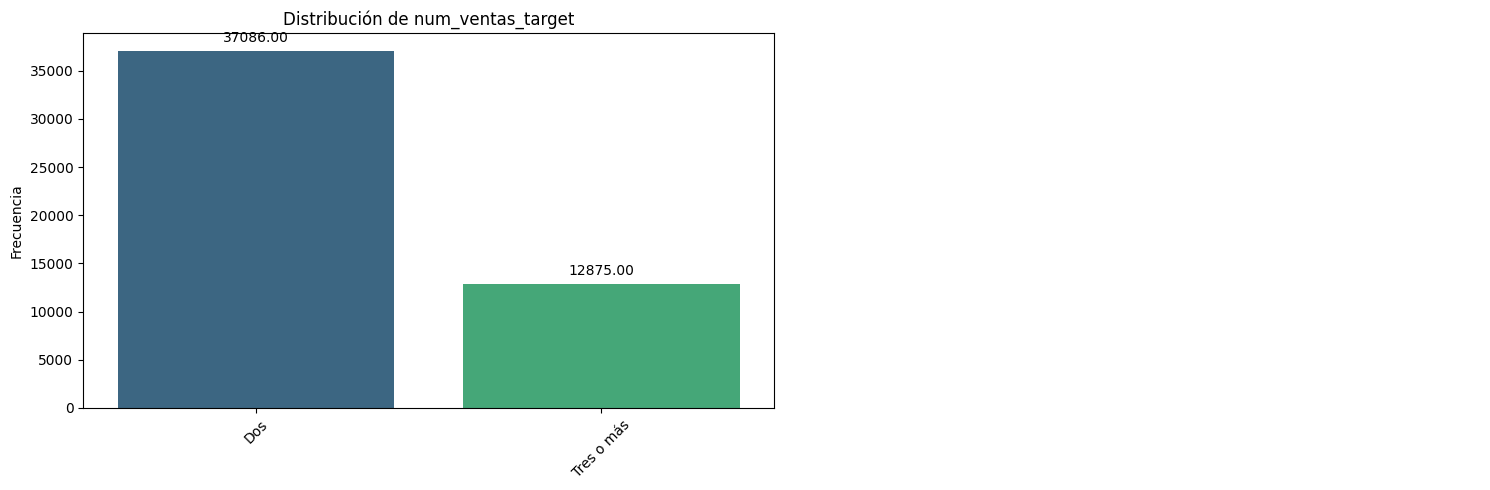

In [55]:
# Solo target
bt.pinta_distribucion_categoricas(train_set, [target], mostrar_valores = True)

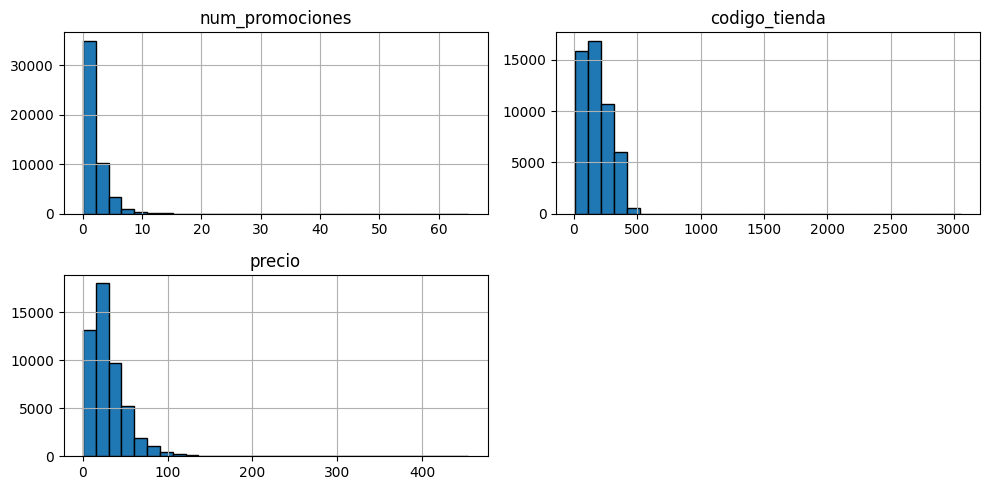

In [56]:
train_set[features_num].hist(bins=30, figsize=(10,5), edgecolor='black');
plt.tight_layout()

In [57]:
train_set_log = train_set.copy()
test_set_log = test_set.copy()

train_set_log[features_num] = train_set[features_num].apply(np.log1p)               # np.log1p(): Aplica el logaritmo natural de 1 más el valor, es más seguro cuando hay valores cercanos a cero.
test_set_log[features_num] = test_set[features_num].apply(np.log1p) 

In [58]:
scaler = StandardScaler()

train_set_scaled = train_set_log.copy()
test_set_scaled = test_set_log.copy()

train_set_scaled[features_num] = scaler.fit_transform(train_set_log[features_num])
test_set_scaled[features_num] = scaler.transform(test_set_log[features_num])

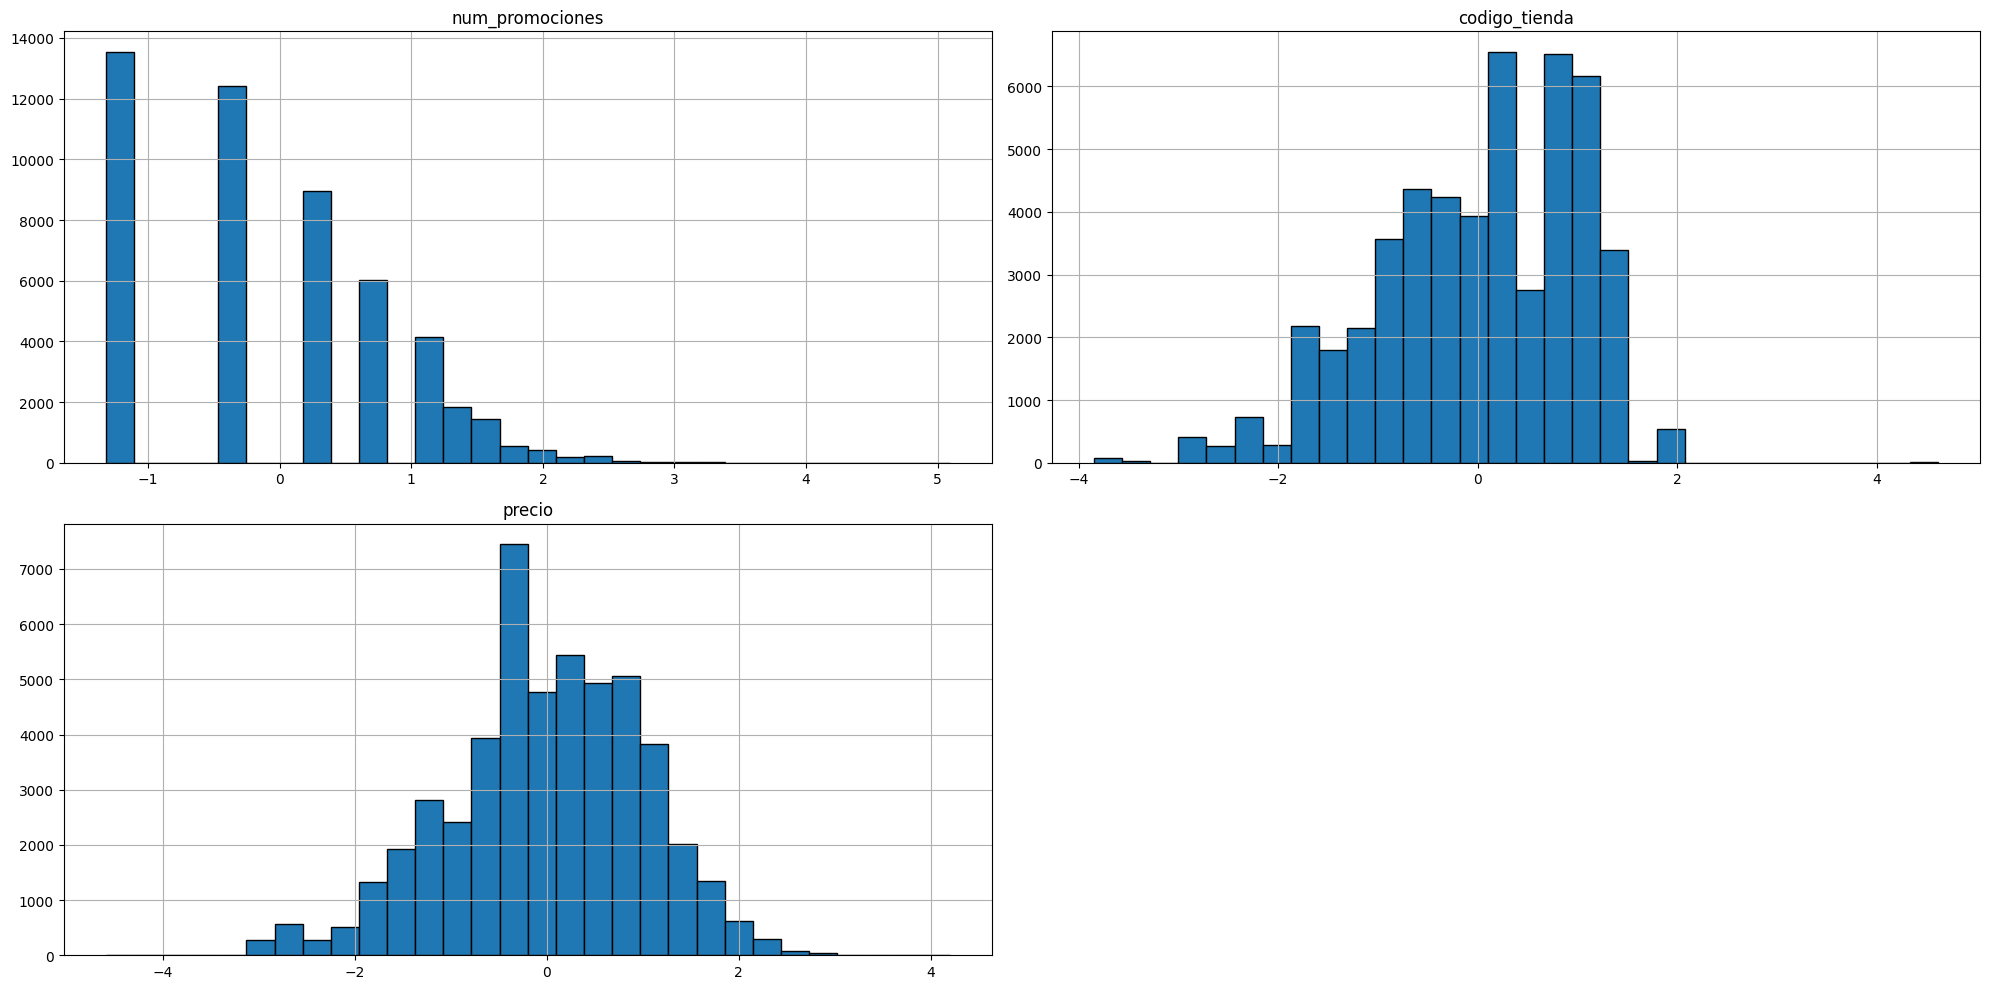

In [59]:
train_set_scal_df = pd.DataFrame(train_set_scaled[features_num])
train_set_scal_df.hist(bins=30, figsize=(20,10), edgecolor='black');
plt.tight_layout()

In [60]:
def plot_multiple_boxplots(df, columns, dim_matriz_visual = 2):
    num_cols = len(columns)
    num_rows = num_cols // dim_matriz_visual + num_cols % dim_matriz_visual
    fig, axes = plt.subplots(num_rows, dim_matriz_visual, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            sns.boxplot(data=df, x=column, ax=axes[i])
            axes[i].set_title(column)

    # Ocultar ejes vacíos
    for j in range(i+1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

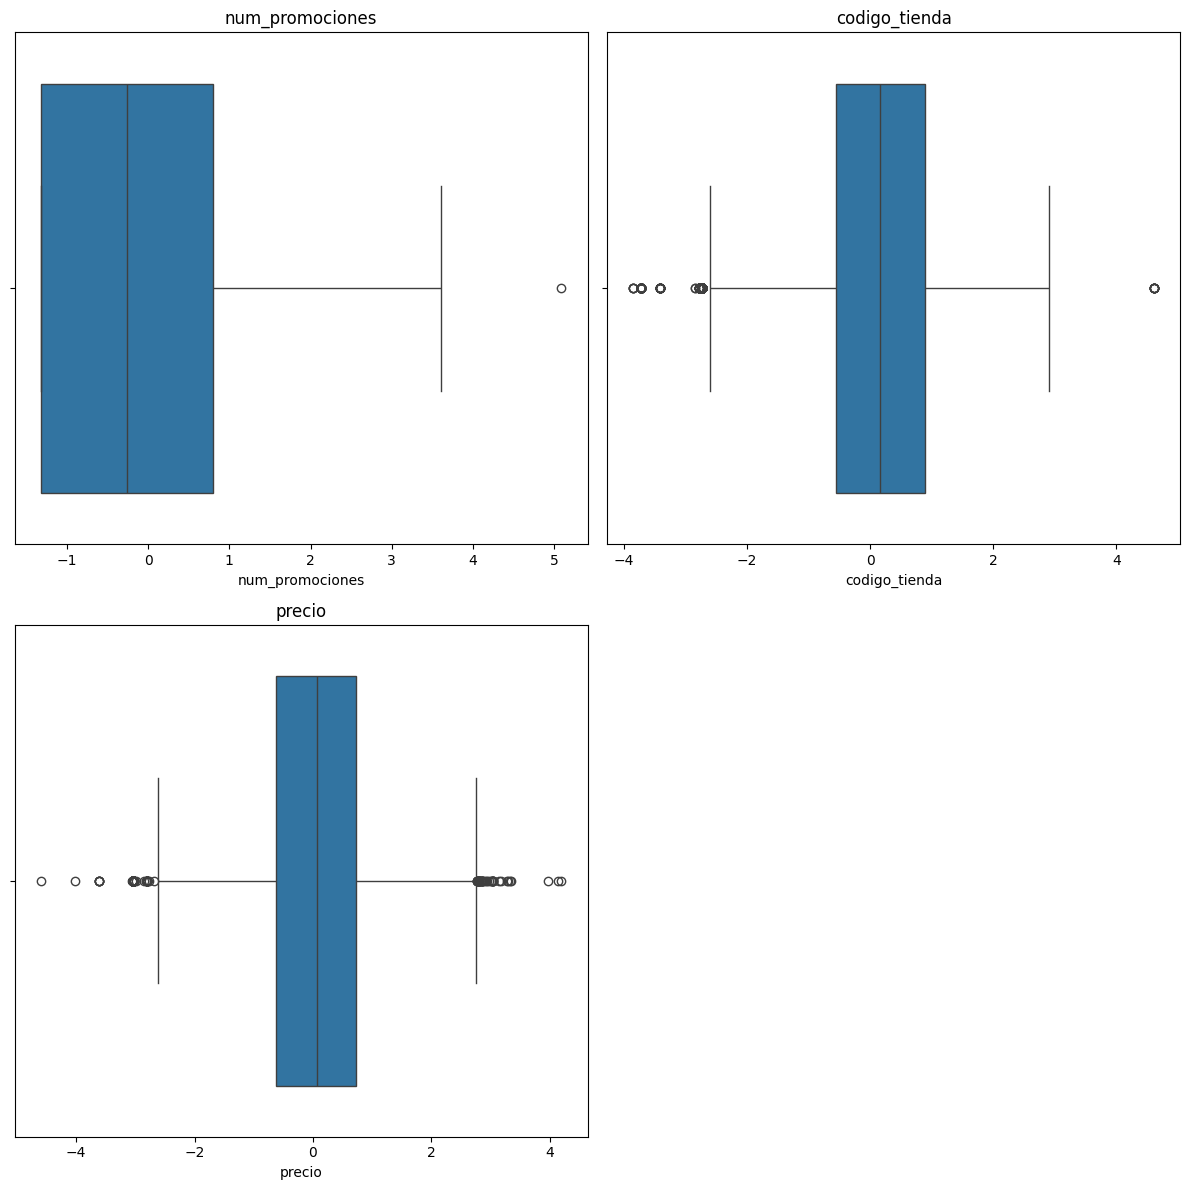

In [61]:
plot_multiple_boxplots(train_set_scaled, features_num, dim_matriz_visual = 2)

DIVIDIMOS X_TRAIN, Y_TRAIN...

In [62]:
X_train = train_set_scaled.drop([target], axis=1)
y_train = train_set_scaled[target]
X_test = test_set_scaled.drop([target], axis=1)
y_test = test_set_scaled[target]

EQUIBRAMOS EL TARGET

In [63]:
'''from imblearn.under_sampling import RandomUnderSampler 

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print("Distribución de clases en Train después del undersampling:", pd.Series.value_counts(y_train_rus))'''

'from imblearn.under_sampling import RandomUnderSampler \n\nrus = RandomUnderSampler(random_state=42)\nX_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)\nprint("Distribución de clases en Train después del undersampling:", pd.Series.value_counts(y_train_rus))'

In [64]:
# SMOTE (Oversampling)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Distribución de clases en Train después del SMOTE:", pd.Series.value_counts(y_train_smote))

Distribución de clases en Train después del SMOTE: num_ventas_target
Dos           37086
Tres o más    37086
Name: count, dtype: int64


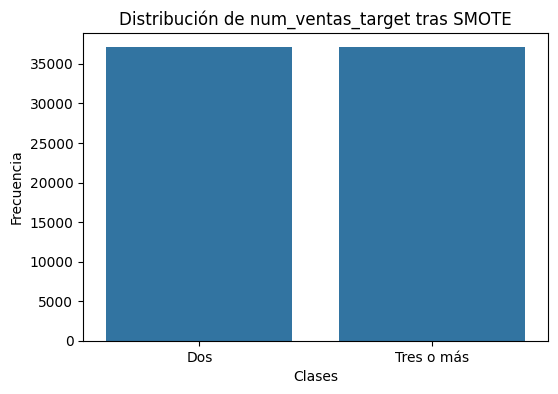

In [65]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_smote)
plt.title('Distribución de num_ventas_target tras SMOTE')
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.show()

PROBAMOS VARIOS MODELOS EN CROSS VALIDATION

In [66]:
from sklearn.model_selection import cross_val_score

modelos = ["KNN", "Logistic", "RandomF"]
metricas = []

# Instanciación de los modelos
knn_clf = KNeighborsClassifier(n_neighbors= 5, weights= "distance")
lr_clf = LogisticRegression(max_iter = 10000, class_weight= "balanced", random_state = 42)
rf_clf = RandomForestClassifier(max_depth = 10, class_weight= "balanced",random_state = 42)

# Bucle para evaluar los modelos
for nombre, modelo in zip(modelos, [knn_clf, lr_clf, rf_clf]):
    print(f"Para {nombre}:", end = " ")

    # Cross validation con métrica de regresión adecuada
    metrica = np.mean(cross_val_score(modelo, X_train_smote, y_train_smote, cv = 5, scoring = "balanced_accuracy")) #balanced_accuracy o recall medio

    # Imprimir la métrica
    print (metrica)

    # Añadir la métrica a la lista
    metricas.append (metrica)

Para KNN: 0.8598252566108341
Para Logistic: 0.5370209267997674
Para RandomF: 0.7468478882667113


HACEMOS GRID SEARCH DEL KNN

In [67]:
knn_clf = KNeighborsClassifier()

param_grid = {
    "n_neighbors": range(1,20),
    "weights": ["uniform","distance"],
    "algorithm":['auto', 'ball_tree', 'kd_tree'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
    }



grid_search = GridSearchCV(knn_clf,
                           param_grid,
                           scoring = "balanced_accuracy") 		# Métrica que quiero optimizar (aquí balanced_accuracy o recall medio)
                                 
grid_search.fit(X_train_smote, y_train_smote)

grid_search.best_params_

{'algorithm': 'auto',
 'metric': 'manhattan',
 'n_neighbors': 1,
 'weights': 'uniform'}

In [68]:
grid_search.best_score_

0.88444377142816

In [69]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         Dos       0.98      0.91      0.95      9272
  Tres o más       0.80      0.95      0.87      3219

    accuracy                           0.92     12491
   macro avg       0.89      0.93      0.91     12491
weighted avg       0.93      0.92      0.93     12491



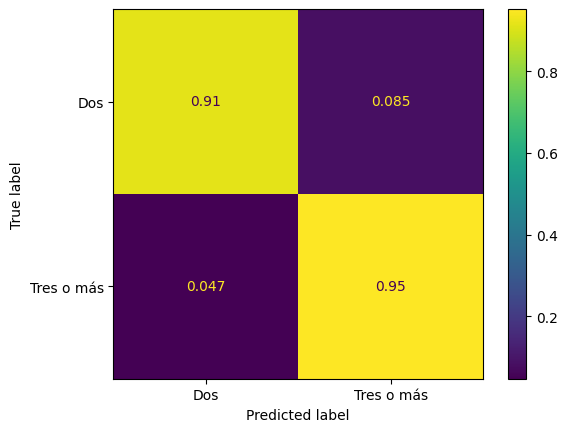

In [70]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true")

CON PERCEPTRÓN SIMPLE

In [71]:
from sklearn.linear_model import Perceptron

per_clf = Perceptron()
per_clf.fit(X_train_smote, y_train_smote)

Perceptron()

In [72]:
y_pred = per_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         Dos       0.00      0.00      0.00      9272
  Tres o más       0.26      1.00      0.41      3219

    accuracy                           0.26     12491
   macro avg       0.13      0.50      0.20     12491
weighted avg       0.07      0.26      0.11     12491



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

MLP con Grid Search

In [73]:
param_grid = {
    'hidden_layer_sizes': [(50,), (50, 50), (50, 50, 50)],  # Diferentes configuraciones de las capas ocultas intermedias (1 capa de 50 neuronas, 2 capas de 50 neuronas cada una, 3 de 50)
    'activation': ['tanh', 'relu'],                         # Funciones de activación (tahn y relu)
    'solver': ['adam', 'sgd'],                              # Optimizadores que se utilizará (Adam y SGD)
    'learning_rate': ['constant', 'adaptive']               # Tasa de aprendizaje, probando tanto la tasa constante como la adaptativa (cambia según las iteraciones)
}

mlp = MLPClassifier(max_iter=1000,                        # Máximo de iteraciones o épocas. A más datos, más iteraciones harán falta.
                    batch_size = 32)                    # En general batch size de 32, 64. También 128, 256


# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=mlp,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy', n_jobs=-1)  # ,n_iter=100) - Nº de iteraciones del algoritmo

# Entrenar GridSearchCV
grid_search.fit(X_train_smote, y_train_smote)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el modelo en el conjunto de prueba
best_mlp = grid_search.best_estimator_
test_accuracy = best_mlp.score(X_test, y_test)
print(f"Accuracy en el conjunto de prueba: {test_accuracy}")

Mejores parámetros encontrados:
{'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Accuracy en el conjunto de prueba: 0.2577055479945561


CON MLP

In [74]:
# MLP
'''
Por defecto viene:
 - 3 capas, con 1 sola capa oculta con 100 neuronas (más input y output)
 - Función de activación es 'relu'.
 - Batch size a "auto" = 200 instancias (lo modificamos a 32 al ser un dataset pequeño)
 - Learning rate a 0.001 y constante (usa un Adam de optimizador con momento y nesterov, ya lo trataremos con más cariño)+
 - Algunos hiperparámetros más que iremos tratando
'''
#Estandarizar con StandardScaler

mlp = MLPClassifier(hidden_layer_sizes=(100),      # Aquí habría 2 hidden layers de 100 neuronas cada una
                    max_iter=100,
                    batch_size=64,
                    early_stopping=True,
                    n_iter_no_change=10,
                    tol=1e-4,
                    random_state=42)


mlp.get_params()

mlp.fit(X_train_smote, y_train_smote)

MLPClassifier(batch_size=64, early_stopping=True, hidden_layer_sizes=100,
              max_iter=100, random_state=42)

In [75]:
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         Dos       0.74      1.00      0.85      9272
  Tres o más       0.00      0.00      0.00      3219

    accuracy                           0.74     12491
   macro avg       0.37      0.50      0.43     12491
weighted avg       0.55      0.74      0.63     12491



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  